# Simulazione Monte Carlo {#sec-montecarlo}

In [6]:
%run ../../config.py # Import the configuration settings
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cmdstanpy
from cmdstanpy import CmdStanModel
cmdstanpy.utils.get_logger().setLevel(logging.ERROR)

In [7]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)

## Stima dell'integrale di un cerchio

Immaginiamo un quadrato di lato 2 centrato sull'origine. Genereremo punti casuali uniformemente distribuiti all'interno di questo quadrato. Per ogni punto $(x, y)$, verificheremo se cade all'interno del cerchio di raggio unitario inscritto nel quadrato, cioè se la distanza dall'origine è minore di 1:

$$
\sqrt{x^2 + y^2} < 1,
$$

che si semplifica a:

$$
x^2 + y^2 < 1.
$$

La proporzione di tali punti rappresenta la proporzione dell'area del quadrato occupata dal cerchio. Poiché il quadrato ha un'area di 4, l'area del cerchio è pari a 4 volte la proporzione dei punti che cadono all'interno del cerchio.

Quindi, se generiamo un numero sufficiente di punti casuali e contiamo quanti di essi cadono all'interno del cerchio, possiamo stimare $\pi$ come:

$$
\pi \approx 4 \times \frac{\text{numero di punti dentro il cerchio}}{\text{numero totale di punti}}.
$$

### Codice Stan

Esaminiamo il corrispondente codice Stan.

```stan
generated quantities {
  real<lower=-1, upper=1> x = uniform_rng(-1, 1);
  real<lower=-1, upper=1> y = uniform_rng(-1, 1);
  int<lower=0, upper=1> inside = x^2 + y^2 < 1;
  real<lower=0, upper=4> pi = 4 * inside;
}
```

1. **Variabili `x` e `y`**:
    - Vengono generate casualmente e uniformemente nell'intervallo $(-1, 1)$. Questo significa che stiamo campionando punti all'interno di un quadrato di lato 2 centrato sull'origine.

2. **Variabile `inside`**:
    - È un indicatore che verifica se il punto $(x, y)$ cade all'interno del cerchio unitario. La condizione $x^2 + y^2 < 1$ è vera se il punto $(x, y)$ è all'interno del cerchio di raggio 1 centrato sull'origine, e falsa altrimenti.
    - Se la condizione è vera, `inside` è impostato a 1, altrimenti a 0.

3. **Variabile `pi`**:
    - `pi` viene calcolata come 4 volte il valore di `inside`.

Il programma Stan genera punti casuali, verifica se cadono all'interno del cerchio e usa la proporzione di punti che cadono all'interno del cerchio per stimare $\pi$. Moltiplicando il valore indicatore per 4, otteniamo una stima di $\pi$ basata su ciascun punto generato. La stima finale di $\pi$ sarà la media di queste stime su molti punti campionati.

### Media Campionaria dell'Indicatore

Dopo aver generato un numero sufficiente di punti casuali e aver verificato quanti di essi cadono all'interno del cerchio, calcoliamo la media campionaria dell'indicatore `inside`. Questo indicatore è uguale a 1 se il punto è dentro il cerchio e a 0 se è fuori. La media di questi valori ci dà la proporzione dei punti che cadono dentro il cerchio.

Questa proporzione è una stima della probabilità che un punto casuale sia all'interno del cerchio. Moltiplicando questa proporzione per 4, otteniamo una stima di $\pi$.

Matematicamente, possiamo scrivere questo processo come segue:

$$
\mathbb{E}[4 \cdot \textrm{I}(\sqrt{X^2 + Y^2} \leq 1)] = \int_{-1}^1 \int_{-1}^1 4 \cdot \textrm{I}(x^2 + y^2 < 1) \, \textrm{d}x \, \textrm{d}y = \pi,
$$

dove $\textrm{I}()$ è l'indicatore che ritorna 1 se il suo argomento è vero e 0 altrimenti.

In altre parole, stiamo calcolando l'aspettativa di 4 volte l'indicatore che un punto casuale $(x, y)$ cade dentro il cerchio unitario. Questo valore atteso è uguale a $\pi$, il che ci permette di stimare $\pi$ usando i metodi Monte Carlo.

### Compilazione e Campionamento

Compiliamo e poi campioniamo dal modello, prendendo un campione di dimensione $M = 10,000$ estrazioni.

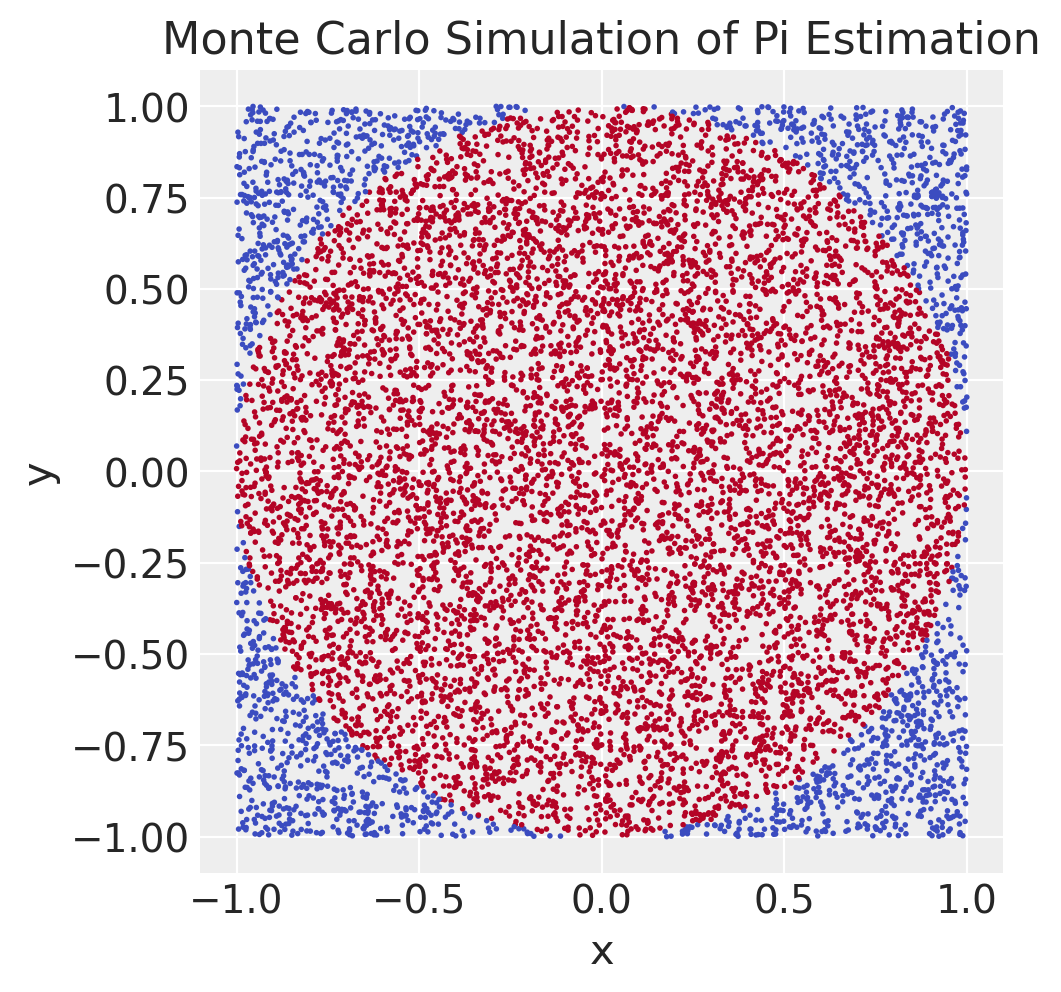

In [8]:
M = 10_000
model = CmdStanModel(stan_file="../../stan/monte-carlo-pi.stan")

sample = model.sample(
    chains=1,
    iter_warmup=1,
    iter_sampling=M,
    show_progress=False,
    show_console=False,
    seed=123,
)

x_draws = sample.stan_variable("x")
y_draws = sample.stan_variable("y")
inside_draws = sample.stan_variable("inside")
pi_draws = sample.stan_variable("pi")

df = pd.DataFrame({"N": 1000, "x": x_draws, "y": y_draws, "inside": inside_draws})

plt.figure(figsize=(5, 5))
plt.scatter(df["x"], df["y"], c=df["inside"], cmap="coolwarm", s=1)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Monte Carlo Simulation of Pi Estimation")
plt.gca().set_aspect("equal", adjustable="box")
plt.show()

Successivamente, calcoliamo la media campionaria dell'indicatore dentro-il-cerchio, che produce una stima della probabilità che un punto sia dentro il cerchio:

In [9]:
Pr_is_inside = np.mean(inside_draws)
pi_hat = np.mean(pi_draws)
print(f"Pr[Y is inside circle] = {Pr_is_inside:.3f};")
print(f"estimate for pi = {pi_hat:.3f}")

Pr[Y is inside circle] = 0.786;
estimate for pi = 3.144


Il valore esatto di $\pi$ fino a tre cifre decimali è $3.142$. Con il nostro metodo, ci avviciniamo a questo valore, ma non lo raggiungiamo esattamente, il che è tipico dei metodi Monte Carlo. Aumentando il numero di estrazioni, l'errore diminuisce. Teoricamente, con un numero sufficiente di estrazioni, possiamo ottenere qualsiasi precisione desiderata; tuttavia, in pratica, dobbiamo accontentarci di pochi decimali di accuratezza nelle nostre stime Monte Carlo. Questo di solito non è un problema, poiché l'incertezza statistica tende a dominare rispetto all'imprecisione numerica nella maggior parte delle applicazioni.